Comparison of simulationed XYZ and transformed XYZ using Sovdat2019 matrix eq8 and eq 9


In [12]:
%load_ext autoreload
%autoreload 2
import sys
import os
import numpy as np

current_dir = os.getcwd()

sys.path.append(os.path.abspath(os.path.join(current_dir, '..')))
from src import *
sys.path.append(os.path.join(current_dir,'..','params'))
from load_params import *


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
# Ecostress simulation eval
ds_xyz = read_csv(os.path.join(current_dir,'..','Simulation','xyz_ECOSTRESS.csv'))
ds_rho_s2a = read_csv(os.path.join(current_dir,'..','Simulation','rho_ECOSTRESS_S2A.csv'))
ds_rho_s2b = read_csv(os.path.join(current_dir,'..','Simulation','rho_ECOSTRESS_S2B.csv'))
ds_rho_s2 = [ds_rho_s2a,ds_rho_s2b]
s2_bnames = ['B4','B3','B2']
xyz_names = ['X','Y','Z']
sensor_names = ['S2A','S2B']

# load test fname list
f = open(os.path.join(current_dir,'..','Simulation','fnames_test.txt'),"r")
fnames_test = f.read().splitlines()
f.close()

def get_inds(fnames,fnames_sub):
    inds = []
    for fname in fnames_sub:
        inds.append(fnames.index(fname))
    return inds

inds = get_inds(ds_xyz['NAME'],fnames_test)

def build_sub_dataset(ds,inds):
    mydict = {}
    for key in list(ds.keys()):
        mydict[key] = np.array(ds[key])[inds]
    return mydict

ds_xyz_sub = build_sub_dataset(ds_xyz,inds)
ds_xyz_sub = [ds_xyz_sub,ds_xyz_sub]

ds_rho_s2_sub = []
for ds in ds_rho_s2:
    ds_rho_s2_sub.append(build_sub_dataset(ds,inds))

def ds_to_matrix(ds_s2,bnames):
    m = len(ds_s2[0][bnames[0]])
    A = np.empty([2*m,3],dtype=float)
    for j in range(len(ds_s2)):
        for i in range(len(bnames)):
                A[j*m:j*m+m,i] = ds_s2[j][bnames[i]]
    return A

matrix_rho = ds_to_matrix(ds_rho_s2_sub,['B4','B3','B2'])
matrix_xyz = ds_to_matrix(ds_xyz_sub,['X','Y','Z'])

Eq8
RMSE = 0.00948,0.00386,0.02146
R2 = 0.98590,0.99779,0.93449


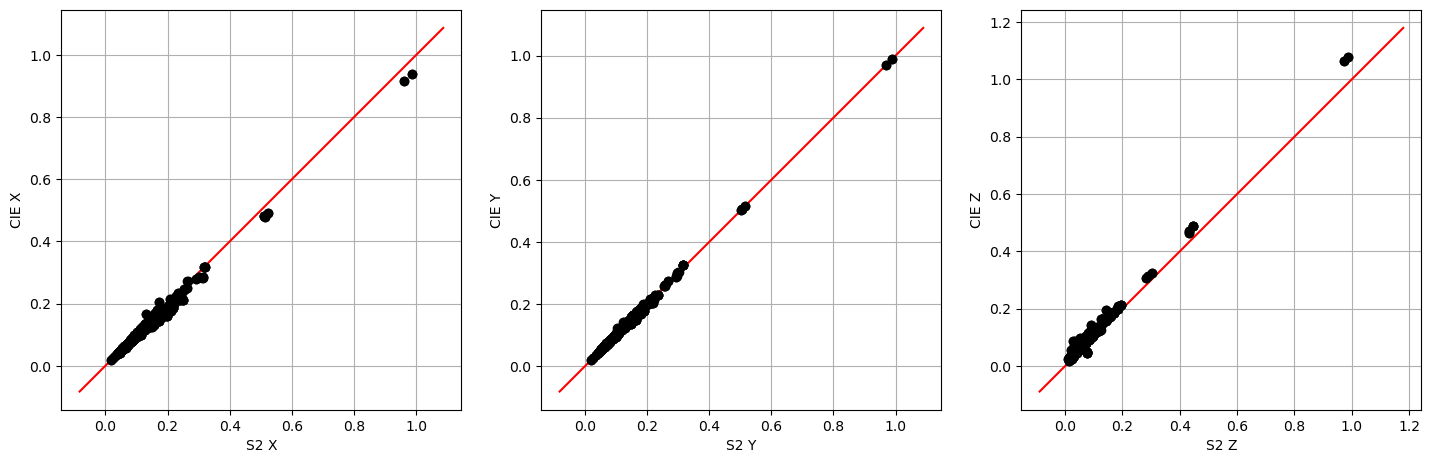

Eq8 new
RMSE = 0.00620,0.00342,0.01218
R2 = 0.99397,0.99826,0.97889


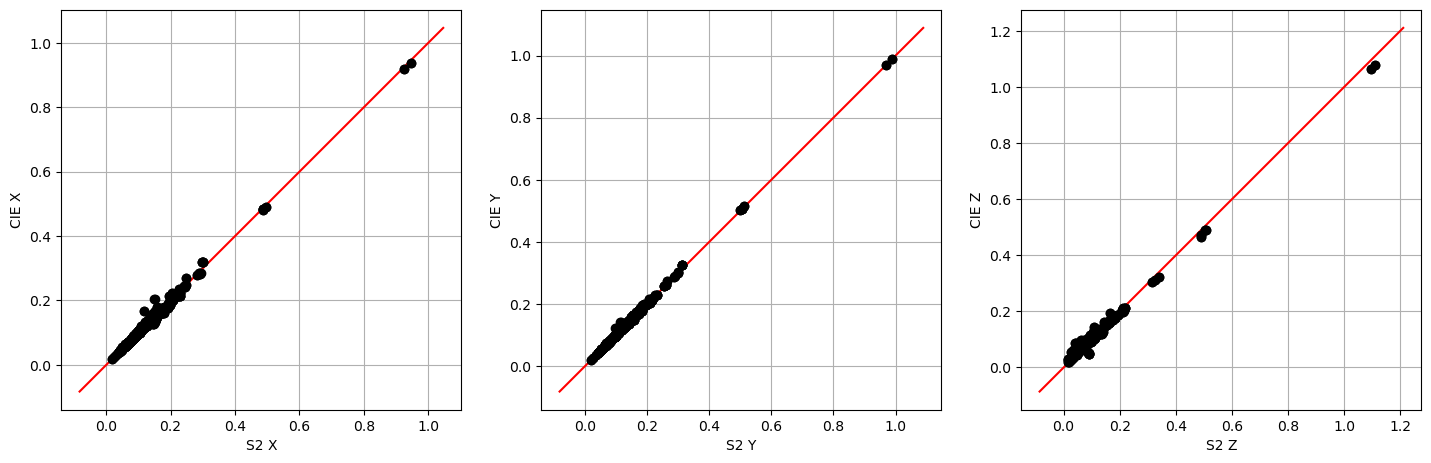

Eq9
RMSE = 0.00826,0.00715,0.02143
R2 = 0.98931,0.99240,0.93466


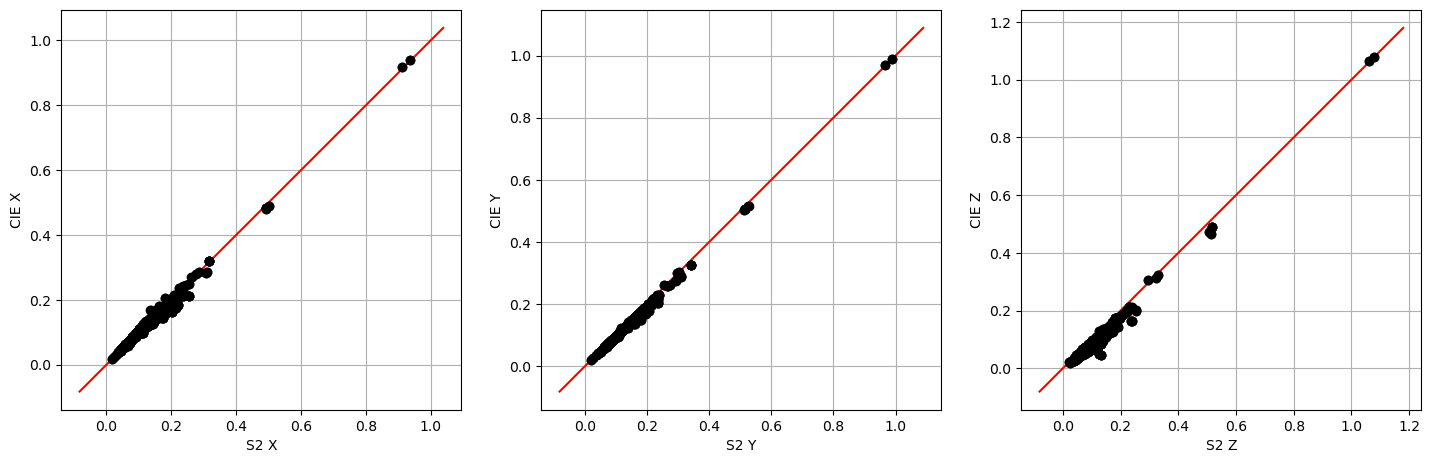

In [75]:
def s2_to_xyz(ds_s2,matrix):
    s2_bnames = ['B4','B3','B2']
    A = np.empty([len(ds_s2['B4']),3],dtype=float)
    for i in range(len(s2_bnames)):
            A[:,i] = ds_s2[s2_bnames[i]]
    B = A @ matrix    
    return B

def s2_to_xyz_ab(ds_s2,matrixs):
    m = len(ds_s2[0]['B4'])
    matrix_xyz = np.empty([2*m,3],dtype=float)
    for s in range(2):
        xyz = s2_to_xyz(ds_s2[s],matrixs[s])
        matrix_xyz[s*m:(s+1)*m,:] = xyz
    return matrix_xyz

def metrics(B,B1):
    # B is the reference, B1 is the prediction
    # RMSE for xyz
    rmses = []
    r2s = []
    for i in range(3):
        y1 = B1[:,i]
        y = B[:,i]
        rmse = np.sqrt(np.mean((y-y1)**2))
        r2 = 1- np.sum((y-y1)**2)/np.sum((y-np.mean(y))**2)
        rmses.append(rmse)
        r2s.append(r2)
    print('RMSE = {:.5f},{:.5f},{:.5f}'.format(rmses[0],rmses[1],rmses[2]))
    print('R2 = {:.5f},{:.5f},{:.5f}'.format(r2s[0],r2s[1],r2s[2]))

def plot_scatter(B,B1,xlabels=['S2 X','S2 Y','S2 Z'],ylabels=['CIE X','CIE Y','CIE Z'],dstfile=None):
    # B is the reference, B1 is the prediction
    X = []
    Y = []
    for i in range(3):
        xs = []
        ys = []
        
        x = list(B1[:,i])
        y = list(B[:,i])
        vmin = np.min([np.min(x),np.min(y)])-0.1
        vmax = np.max([np.max(x),np.max(y)])+0.1
        xs.append([vmin,vmax])
        ys.append([vmin,vmax])
        
        xs.append(x)
        ys.append(y)
        X.append(xs)
        Y.append(ys)

    legends = [None,None,None]
    fmts = [['r-','ko']]*len(s2_bnames)
    solid_markers = [[True,True,True]]*len(X)
    grid = [True]*len(X)
    # xlims = [(vmin,vmax)]*len(X)
    xlims = None
    ylims = xlims
    plot_figures(X, Y, xlabels=xlabels, ylabels=ylabels, titles=None, ncol=3, cell_width=4, cell_height=4,
                     left_margin=0.8, right_margin=0.5, top_margin=0.5, bottom_margin=0.5,
                     h_margin=0.8, v_margin=0.5, fmts=fmts, grid=grid, solid_markers=solid_markers, 
                     legends=legends, dstfile=dstfile,xlims=xlims,ylims=ylims)
    


print('Eq8')
matrixs = [matrix_s2l2ab4b3b2_to_xyzd65_sovdat2019_eq8,matrix_s2l2ab4b3b2_to_xyzd65_sovdat2019_eq8]
matrix_xyz_s2 = s2_to_xyz_ab(ds_rho_s2_sub,matrixs)
metrics(matrix_xyz,matrix_xyz_s2)
plot_scatter(matrix_xyz,matrix_xyz_s2,dstfile=os.path.join(current_dir,'scat_xyz_Eq8.png'))

print('Eq8 new')
matrixs = [matrix_s2l2ab4b3b2_to_xyzd65_sovdat2019_eq8_new,matrix_s2l2ab4b3b2_to_xyzd65_sovdat2019_eq8_new]
matrix_xyz_s2 = s2_to_xyz_ab(ds_rho_s2_sub,matrixs)
metrics(matrix_xyz,matrix_xyz_s2)
plot_scatter(matrix_xyz,matrix_xyz_s2,dstfile=os.path.join(current_dir,'scat_xyz_Eq8_new.png'))

print('Eq9')
matrixs = [matrix_s2l2ab4b3b2_to_xyzd65_sovdat2019_eq9,matrix_s2l2ab4b3b2_to_xyzd65_sovdat2019_eq9]
matrix_xyz_s2 = s2_to_xyz_ab(ds_rho_s2_sub,matrixs)
metrics(matrix_xyz,matrix_xyz_s2)
plot_scatter(matrix_xyz,matrix_xyz_s2,dstfile=os.path.join(current_dir,'scat_xyz_Eq9.png'))

Eq8
RMSE = 0.54046,4.33838,7.83962
R2 = 0.99639,0.50285,-0.42765
metric CIE76 = 8.59366


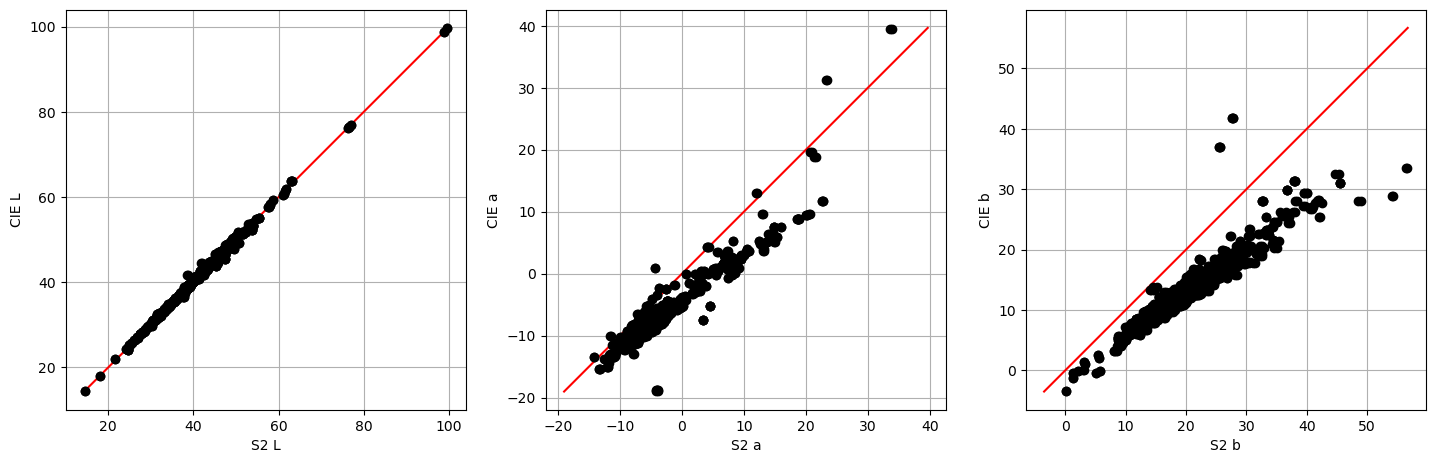

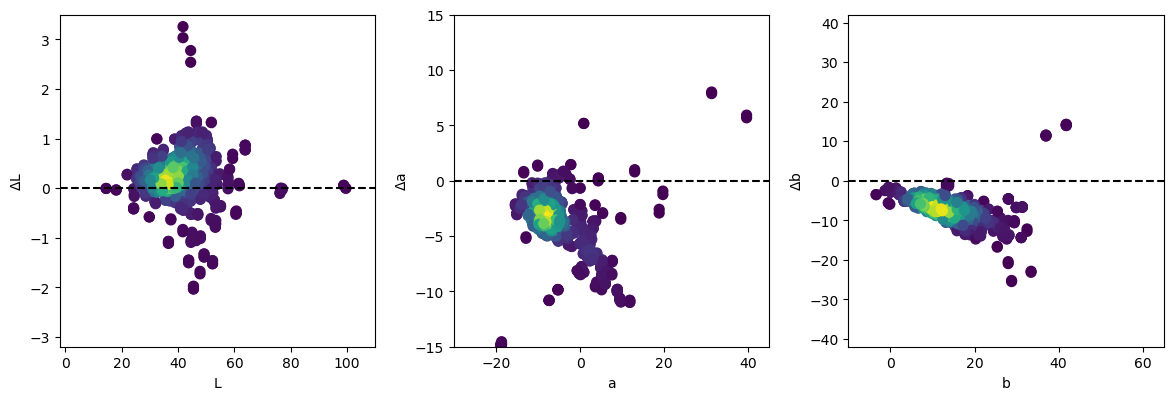

Eq8 new
RMSE = 0.47552,2.13150,4.54807
R2 = 0.99721,0.87999,0.51951
metric CIE76 = 4.17855


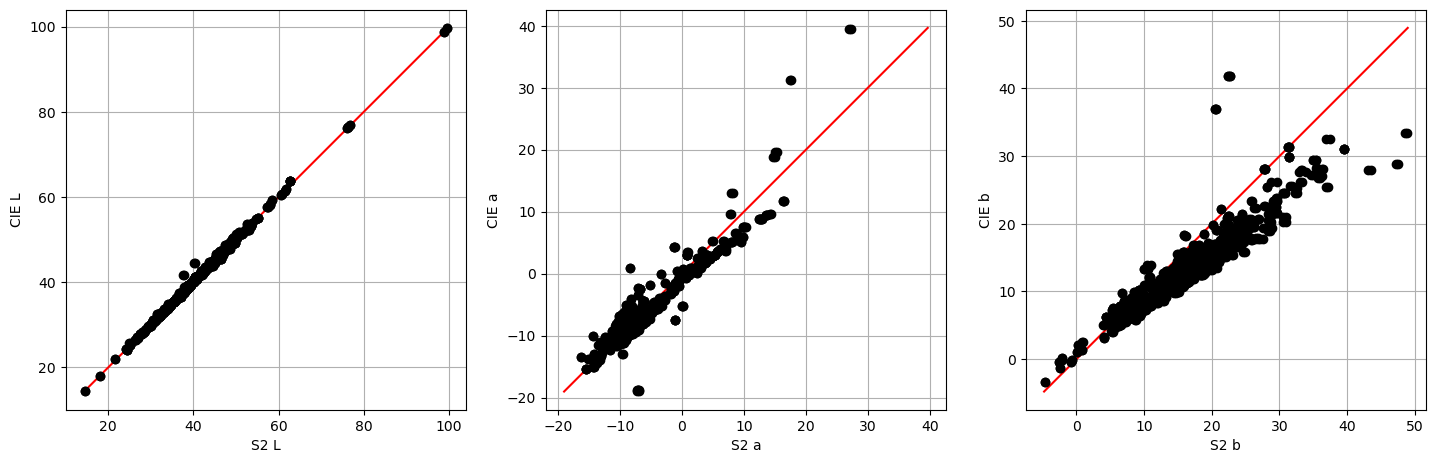

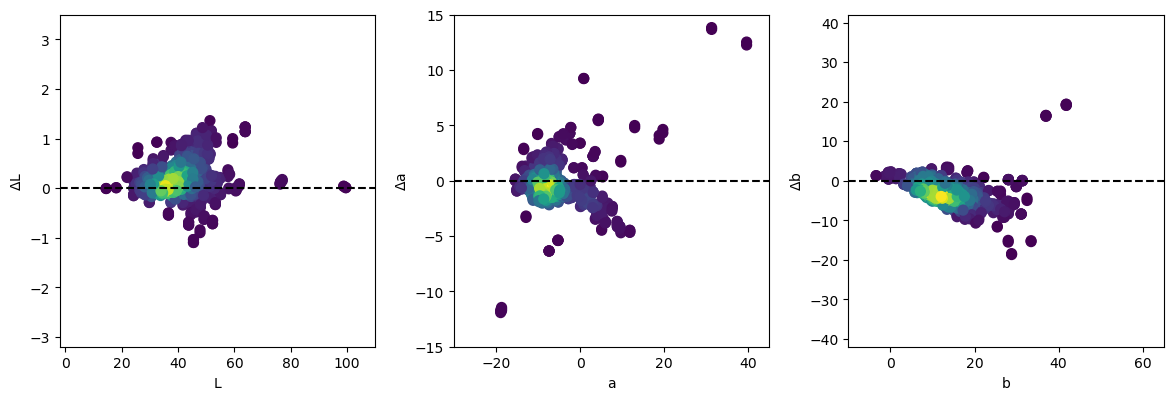

Eq9
RMSE = 0.98232,5.35422,5.32444
R2 = 0.98809,0.24277,0.34146
metric CIE76 = 6.58018


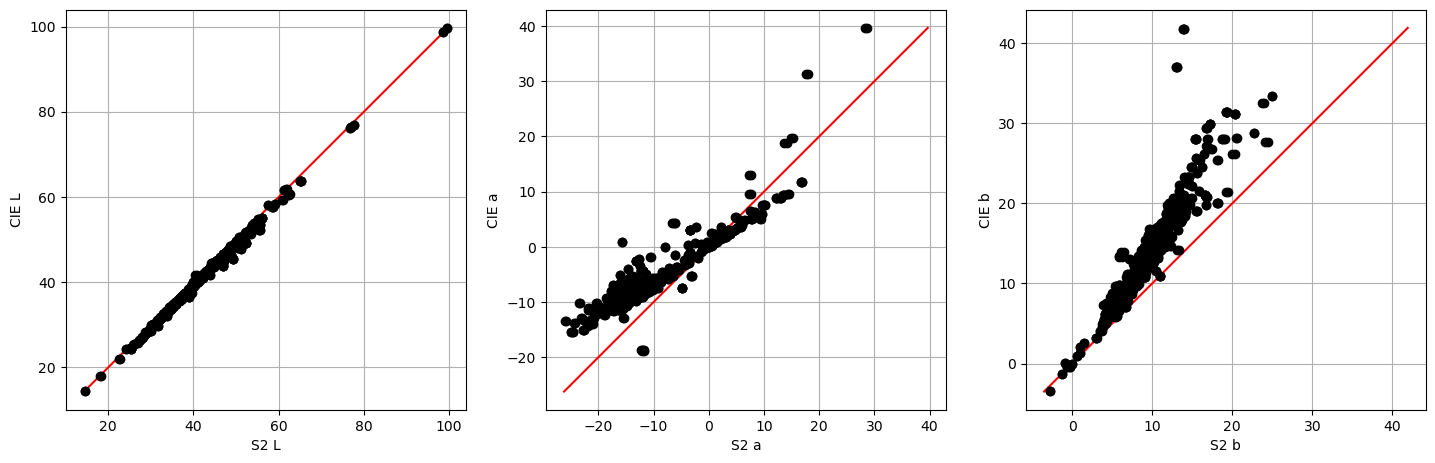

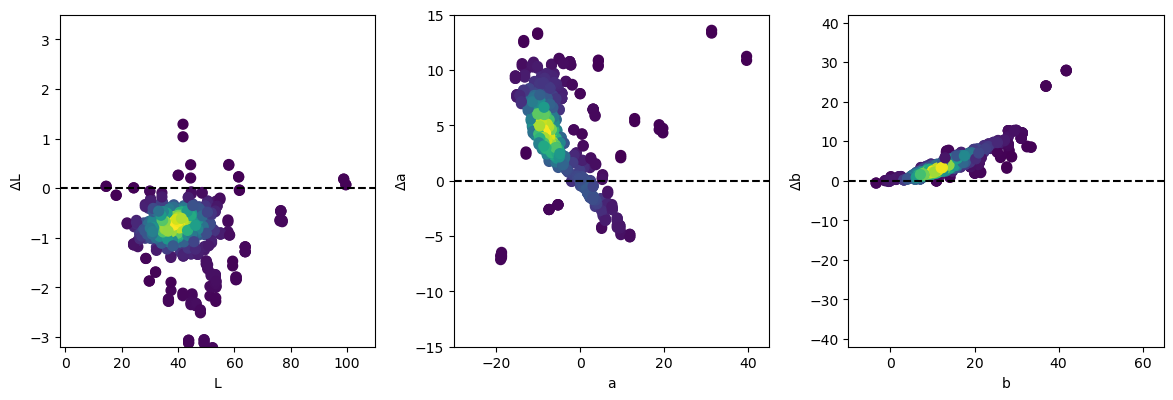

In [77]:
matrix_lab = xyz_d65_to_lab(matrix_xyz)

def metric_cie76(lab1,lab2):
    v = (lab1-lab2)**2
    v = np.sum(v,axis=1)
    v = np.sqrt(v)
    print('metric CIE76 = {:.5f}'.format(np.mean(v)))
    return v

from scipy.stats import gaussian_kde
def plot_scatter_lab(matrix_lab,matrix_lab_s2,xlabels=['L','a','b'],ylabels=['$\Delta$L','$\Delta$a','$\Delta$b'],dstfile=None):
    X = []
    Y = []
    for i in range(3):
        x = matrix_lab[:,i]
        y = matrix_lab_s2[:,i]
        d = x-y
        X.append(x)
        Y.append(d)
    legends = [None,None,None]
    fmts = [['ko']]*len(X)
    solid_markers = [[True,True,True]]*len(X)
    grid = [True]*len(X)
    
    xlims = [(-2,110),(-30,45),(-10,65)]
    # xlims = None
    ylims = [(-3.2,3.5),(-15,15),(-42,42)]
    # plot_figures(X, Y, xlabels=xlabels, ylabels=ylabels, titles=None, ncol=3, cell_width=4, cell_height=4,
    #                  left_margin=0.5, right_margin=0.5, top_margin=0.5, bottom_margin=0.5,
    #                  h_margin=0.8, v_margin=0.5, fmts=fmts, grid=grid, solid_markers=solid_markers, 
    #                  legends=legends, dstfile=dstfile,xlims=xlims,ylims=ylims)
    
    plt.figure(figsize=[12,4])
    for i in range(3):
        x = X[i]
        y = Y[i]
        xy = np.vstack([x, y])
        z = gaussian_kde(xy)(xy)
        
        plt.subplot(131+i)
        plt.plot(xlims[i],[0,0],'k--')
        plt.scatter(x, y, c=z, s=50, cmap='viridis')
        plt.xlim(xlims[i])
        plt.ylim(ylims[i])
        plt.xlabel(xlabels[i])
        plt.ylabel(ylabels[i])
    plt.subplots_adjust(left=0.06, right=0.98, top=0.95, bottom=0.12,wspace=0.25, hspace=0.2)
    if dstfile:
        plt.savefig(dstfile)
    plt.show()
    
        
    
print('Eq8')
matrixs = [matrix_s2l2ab4b3b2_to_xyzd65_sovdat2019_eq8,matrix_s2l2ab4b3b2_to_xyzd65_sovdat2019_eq8]
matrix_xyz_s2 = s2_to_xyz_ab(ds_rho_s2_sub,matrixs)
matrix_lab_s2 = xyz_d65_to_lab(matrix_xyz_s2)
metrics(matrix_lab,matrix_lab_s2)
metric_cie76(matrix_lab,matrix_lab_s2)
plot_scatter(matrix_lab,matrix_lab_s2,xlabels=['S2 L','S2 a','S2 b'],ylabels=['CIE L','CIE a','CIE b'],dstfile=os.path.join(current_dir,'scat_lab_Eq8.png'))
plot_scatter_lab(matrix_lab,matrix_lab_s2,dstfile=os.path.join(current_dir,'scat_delta_Lab_Eq8.png'))

print('Eq8 new')
matrixs = [matrix_s2l2ab4b3b2_to_xyzd65_sovdat2019_eq8_new,matrix_s2l2ab4b3b2_to_xyzd65_sovdat2019_eq8_new]
matrix_xyz_s2 = s2_to_xyz_ab(ds_rho_s2_sub,matrixs)
matrix_lab_s2 = xyz_d65_to_lab(matrix_xyz_s2)
metrics(matrix_lab,matrix_lab_s2)
metric_cie76(matrix_lab,matrix_lab_s2)
plot_scatter(matrix_lab,matrix_lab_s2,xlabels=['S2 L','S2 a','S2 b'],ylabels=['CIE L','CIE a','CIE b'],dstfile=os.path.join(current_dir,'scat_lab_Eq8_new.png'))
plot_scatter_lab(matrix_lab,matrix_lab_s2,dstfile=os.path.join(current_dir,'scat_delta_Lab_Eq8_new.png'))

print('Eq9')
matrixs = [matrix_s2l2ab4b3b2_to_xyzd65_sovdat2019_eq9,matrix_s2l2ab4b3b2_to_xyzd65_sovdat2019_eq9]
matrix_xyz_s2 = s2_to_xyz_ab(ds_rho_s2_sub,matrixs)
matrix_lab_s2 = xyz_d65_to_lab(matrix_xyz_s2)
metrics(matrix_lab,matrix_lab_s2)
metric_cie76(matrix_lab,matrix_lab_s2)
plot_scatter(matrix_lab,matrix_lab_s2,xlabels=['S2 L','S2 a','S2 b'],ylabels=['CIE L','CIE a','CIE b'],dstfile=os.path.join(current_dir,'scat_lab_Eq9.png'))
plot_scatter_lab(matrix_lab,matrix_lab_s2,dstfile=os.path.join(current_dir,'scat_delta_Lab_Eq9.png'))

Eq8
metric CIE76 = 8.59366
metric CIE76 = 4.17855
metric CIE76 = 8.59366


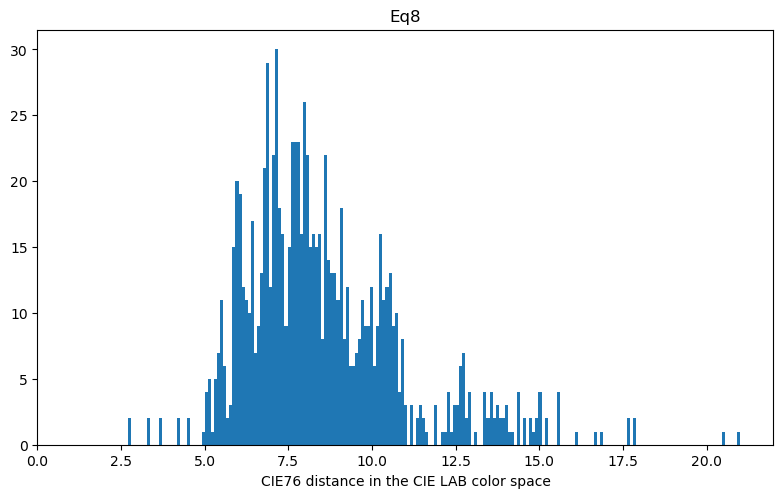

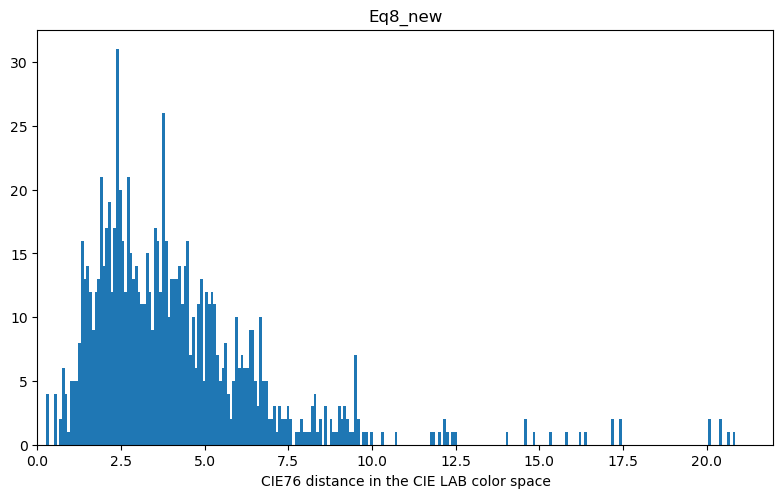

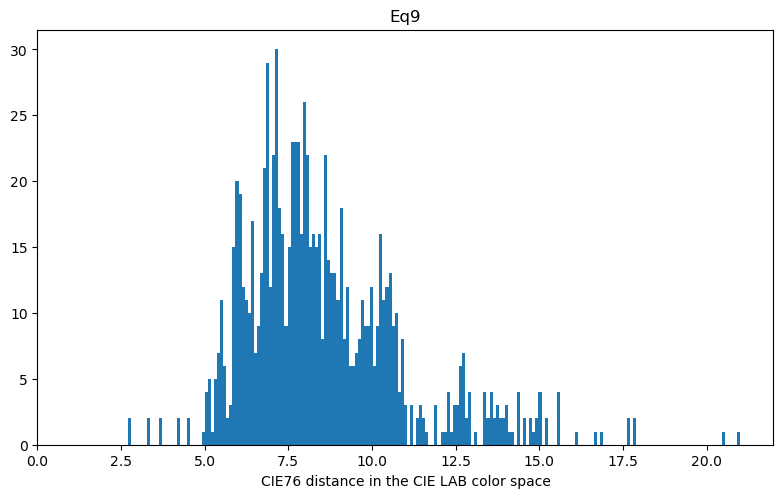

In [93]:
# histogram
print('Eq8')
matrixs_list = [[matrix_s2l2ab4b3b2_to_xyzd65_sovdat2019_eq8,matrix_s2l2ab4b3b2_to_xyzd65_sovdat2019_eq8],
                [matrix_s2l2ab4b3b2_to_xyzd65_sovdat2019_eq8_new,matrix_s2l2ab4b3b2_to_xyzd65_sovdat2019_eq8_new],
                [matrix_s2l2ab4b3b2_to_xyzd65_sovdat2019_eq8,matrix_s2l2ab4b3b2_to_xyzd65_sovdat2019_eq8]]
                
labels = ['Eq8','Eq8_new','Eq9']

cie76s = []
for i in range(3):
    matrixs = matrixs_list[i]
    matrix_xyz_s2 = s2_to_xyz_ab(ds_rho_s2_sub,matrixs)
    matrix_lab_s2 = xyz_d65_to_lab(matrix_xyz_s2)
    cie76 = metric_cie76(matrix_lab,matrix_lab_s2)
    cie76s.append(cie76)


for i in range(3):
    plt.figure(figsize=[8,5])
    plt.hist(cie76s[i],bins=255)
    plt.xlim((0,22))
    plt.title(labels[i])
    plt.subplots_adjust(left=0.06, right=0.98, top=0.95, bottom=0.12,wspace=0.2, hspace=0.2)
    plt.xlabel('CIE76 distance in the CIE LAB color space')
    plt.savefig(os.path.join(current_dir,'hist_cie76_distance_'+labels[i]+'.png'))
    plt.show()